In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [8]:
# Load Plant 1
p1_gen = pd.read_csv("Plant_1_Generation_Data.csv")
p1_weather = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")

# Load Plant 2
p2_gen = pd.read_csv("Plant_2_Generation_Data.csv")
p2_weather = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")



In [9]:
for df in [p1_gen, p1_weather, p2_gen, p2_weather]:
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst=True, errors='coerce')


C:\Users\vaishali singh\AppData\Local\Temp\ipykernel_16236\1475415547.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst=True, errors='coerce')
C:\Users\vaishali singh\AppData\Local\Temp\ipykernel_16236\1475415547.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst=True, errors='coerce')
C:\Users\vaishali singh\AppData\Local\Temp\ipykernel_16236\1475415547.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst=True, errors='coerce')


In [10]:
# Remove duplicates in weather before merge
p1_weather = p1_weather.drop_duplicates(subset='DATE_TIME')
p2_weather = p2_weather.drop_duplicates(subset='DATE_TIME')

# Merge
plant1 = pd.merge(p1_gen, p1_weather, on='DATE_TIME', how='inner')
plant2 = pd.merge(p2_gen, p2_weather, on='DATE_TIME', how='inner')


In [11]:
for df in [plant1, plant2]:
    df['hour'] = df['DATE_TIME'].dt.hour
    df['day_of_week'] = df['DATE_TIME'].dt.dayofweek
    df['month'] = df['DATE_TIME'].dt.month
    df['is_daylight'] = (df['IRRADIATION'] > 0).astype(int)


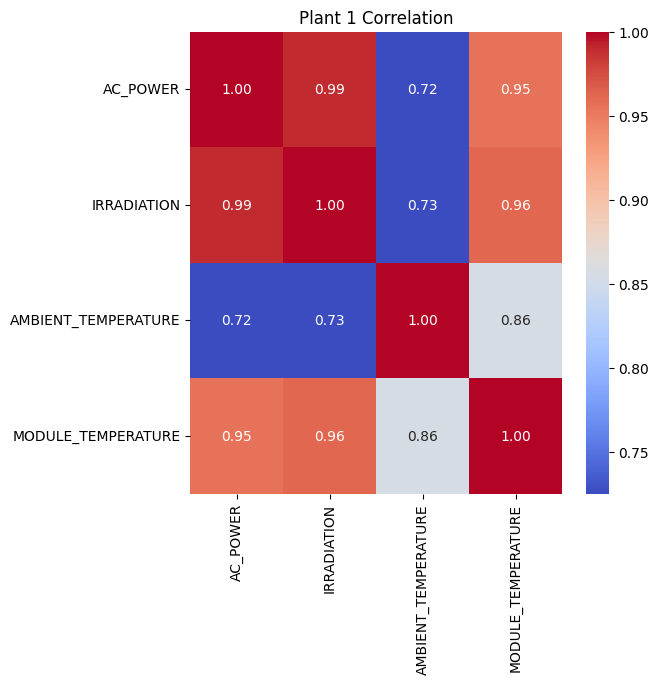

In [12]:
plt.figure(figsize=(6,6))
sns.heatmap(plant1[['AC_POWER','IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Plant 1 Correlation')
plt.show()


In [13]:
def train_models(df, plant_name):
    features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
                'hour', 'day_of_week', 'month', 'is_daylight']
    target = 'AC_POWER'
    
    X = df[features]
    y = df[target]
    
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
    
    return {
        'Plant': plant_name,
        'RF_MAE': mae_rf,
        'RF_RMSE': rmse_rf,
        'LR_MAE': mae_lr,
        'LR_RMSE': rmse_lr
    }


In [14]:
results = []
results.append(train_models(plant1, "Plant 1"))
results.append(train_models(plant2, "Plant 2"))

results_df = pd.DataFrame(results)
results_df


,Plant,RF_MAE,RF_RMSE,LR_MAE,LR_RMSE
0,Plant 1,17.678696,52.804386,26.051323,57.542690
1,Plant 2,60.170460,159.473806,96.750212,166.956871


In [16]:
plant1['PLANT'] = 1
plant2['PLANT'] = 2
combined = pd.concat([plant1, plant2], ignore_index=True)

features_combined = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
                     'hour', 'day_of_week', 'month', 'is_daylight', 'PLANT']
target = 'AC_POWER'

Xc = combined[features_combined]
yc = combined[target]

split_c = int(len(Xc) * 0.8)
Xc_train, Xc_test = Xc.iloc[:split_c], Xc.iloc[split_c:]
yc_train, yc_test = yc.iloc[:split_c], yc.iloc[split_c:]

rf_c = RandomForestRegressor(random_state=42)
rf_c.fit(Xc_train, yc_train)
pred_c_rf = rf_c.predict(Xc_test)

mae_c_rf = mean_absolute_error(yc_test, pred_c_rf)
rmse_c_rf = math.sqrt(mean_squared_error(yc_test, pred_c_rf))

print("Combined Model (Random Forest) → MAE:", mae_c_rf, "RMSE:", rmse_c_rf)


Combined Model (Random Forest) → MAE: 81.92939194092551 RMSE: 203.0220156102264


In [17]:
results_df.to_csv("model_comparison.csv", index=False)
